# Data Scientist Associate Case Study

## Company Background
EMO is a manufacturer of motorcycles. The company successfully launched its first electric moped in India in 2019. The product team knows how valuable owner reviews are in making improvements to their mopeds. 

Unfortunately they often get reviews from people who never owned the moped. They don’t want to consider this feedback, so would like to find a way to identify reviews from these people. They have obtained data from other mopeds, where they know if the reviewer owned the moped or not. They think this is equivalent to their own reviews.   


## Customer Question
Your manager has asked you to answer the following:
- Can you predict which reviews come from people who have never owned the moped before?  


## Dataset
The dataset contains reviews about other mopeds from a local website. The data you will use for this analysis can be accessed here: `"data/moped.csv"`

| Column Name      | Criteria                                                                                                                                                                    |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Used it for      | Character, the purpose of the electric moped for the user, one of “Commuting”, “Leisure”.                                                                                   |
| Owned for        | Character, duration of ownership of vehicle one of  “<= 6 months”, “> 6 months”, “Never Owned”.  Rows that indicate ownership should be combined into the category “Owned”. |
| Model name       | Character, the name of the electric moped.                                                                                                                                   |
| Visual Appeal    | Numeric, visual appeal rating (on a 5 point scale, replace missing values with 0).                                                                                           |
| Reliability      | Numeric, reliability rating (on a 5 point scale, replace missing values with 0).                                                                                             |
| Extra Feature    | Numeric, extra feature rating (on a 5 point scale, replace missing values with 0).                                                                                         |
| Comfort          | Numeric, comfort rating (on a 5 point scale, replace missing values with 0).                                                                                                 |
| Maintenance cost | Numeric, maintenance cost rating (on a 5 point scale, replace missing values with 0).                                                                                        |
| Value for money  | Numeric, value for money rating (on a 5 point scale, replace missing values with 0).                                                                                         |

# Data Scientist Associate Case Study Submission

Use this template to complete your analysis and write up your summary for submission.


## Data Validation Process

Installing vip [0.3.2] ...
	OK [linked cache]
Installing xgboost [1.6.0.1] ...
	OK [linked cache]
Installing ranger [0.14.1] ...
	OK [linked cache]
Installing visdat [0.5.3] ...
	OK [linked cache]
Installing naniar [0.6.1] ...
	OK [linked cache]
Rows: 713
Columns: 9
$ Used.it.for      <chr> "Commuting", "Leisure", "Commuting", "Commuting", "Co…
$ Owned.for        <chr> "Never owned", "> 6 months", "<= 6 months", "> 6 mont…
$ Model.Name       <chr> "TVS iQube", "TVS iQube", "TVS iQube", "TVS iQube", "…
$ Visual.Appeal    <dbl> 3, 3, 4, 1, 3, 5, 3, 3, 3, 5, 5, 4, 5, 4, 2, 4, 4, 3,…
$ Reliability      <dbl> 4, 1, 4, 1, 4, 1, 2, 1, 3, 3, 5, 5, 5, 4, 1, 4, 2, 1,…
$ Extra.Features   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Comfort          <dbl> 4, 3, 5, 1, 3, 5, 4, 2, 4, 4, 5, 5, 5, 4, NA, 3, 4, N…
$ Maintenance.cost <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Value.for.Money  <dbl> 1, 3, 2, 1, 2, 2, 3, 1, 3, 3, 5, 5, 4, 2, 2, 5, 1, NA…


variable,n_miss,pct_miss
<chr>,<int>,<dbl>
Maintenance.cost,537,75.31557
Extra.Features,530,74.33380
Value.for.Money,343,48.10659
Comfort,203,28.47125
Used.it.for,0,0.00000
Owned.for,0,0.00000
Model.Name,0,0.00000
Visual.Appeal,0,0.00000
Reliability,0,0.00000


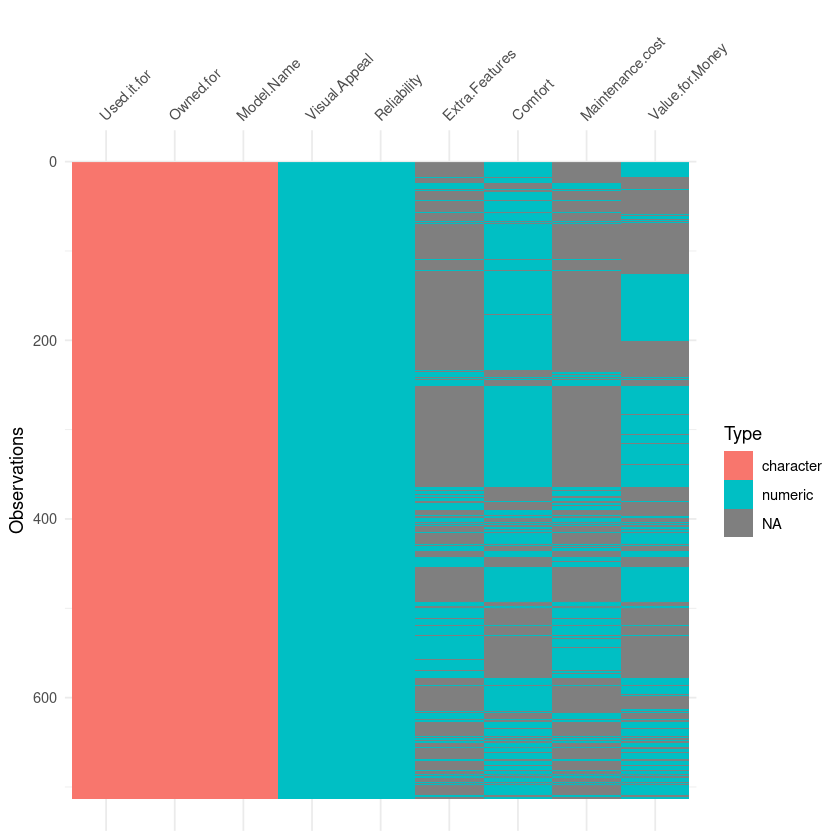

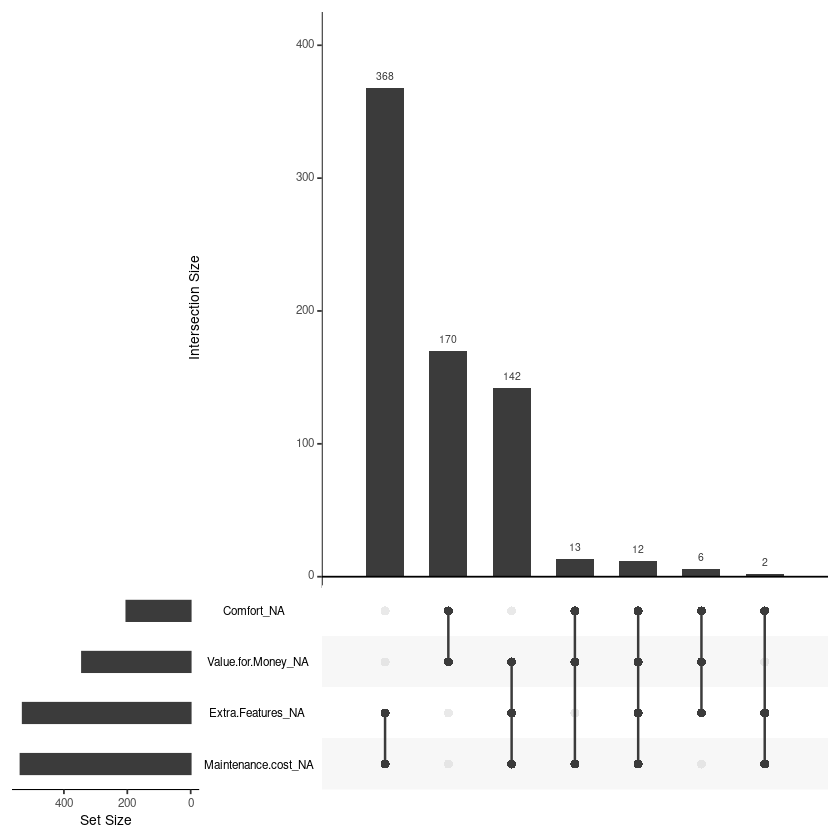

In [249]:
# Install and load the necessary packages and data
install.packages('vip')
install.packages('xgboost')
install.packages('ranger')
install.packages('visdat')
install.packages('naniar')
library(tidyverse)
library(forcats)
library(tidyr)
library(caTools)
library(naniar)
library(visdat)
library(tidymodels)
library(psych)
library(ranger)
moped<-read.csv("data/moped.csv")
glimpse(moped)

# Check for missing Values
miss_var_summary(moped)
vis_dat(moped)
gg_miss_upset(moped)

It appears that 'maintenance cost' and 'extra features' has the most missing values and missing values for these variables tend to appear together. While missing values for 'comfort' tend to appear where rows for the initially stated variables are not missing. With this, there seems to be an associated with 'maintenance cost', 'extra features', and 'comfort'. 

In [250]:
# Transform the values of the column "Owned.for" and add a column named "owned" where "0" = "Never owned" and "1" = "Owned".

moped_mod<- moped |> 
	mutate(ownership=if_else(
        			Owned.for=="Never owned","Never owned","Owned"))|>
	mutate_if(is.character, as.factor)|>
	select(-Owned.for)

# Change the NAs with 0
moped_nan_replaced <- moped_mod %>% replace(is.na(.),0)




Rows: 713
Columns: 9
$ Used.it.for      <fct> Commuting, Leisure, Commuting, Commuting, Commuting, …
$ Model.Name       <fct> TVS iQube, TVS iQube, TVS iQube, TVS iQube, TVS iQube…
$ Visual.Appeal    <dbl> 3, 3, 4, 1, 3, 5, 3, 3, 3, 5, 5, 4, 5, 4, 2, 4, 4, 3,…
$ Reliability      <dbl> 4, 1, 4, 1, 4, 1, 2, 1, 3, 3, 5, 5, 5, 4, 1, 4, 2, 1,…
$ Extra.Features   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,…
$ Comfort          <dbl> 4, 3, 5, 1, 3, 5, 4, 2, 4, 4, 5, 5, 5, 4, 0, 3, 4, 0,…
$ Maintenance.cost <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Value.for.Money  <dbl> 1, 3, 2, 1, 2, 2, 3, 1, 3, 3, 5, 5, 4, 2, 2, 5, 1, 0,…
$ ownership        <fct> Never owned, Owned, Owned, Owned, Owned, Owned, Owned…


variable,n_miss,pct_miss
<chr>,<int>,<dbl>
Used.it.for,0,0
Model.Name,0,0
Visual.Appeal,0,0
Reliability,0,0
Extra.Features,0,0
Comfort,0,0
Maintenance.cost,0,0
Value.for.Money,0,0
ownership,0,0


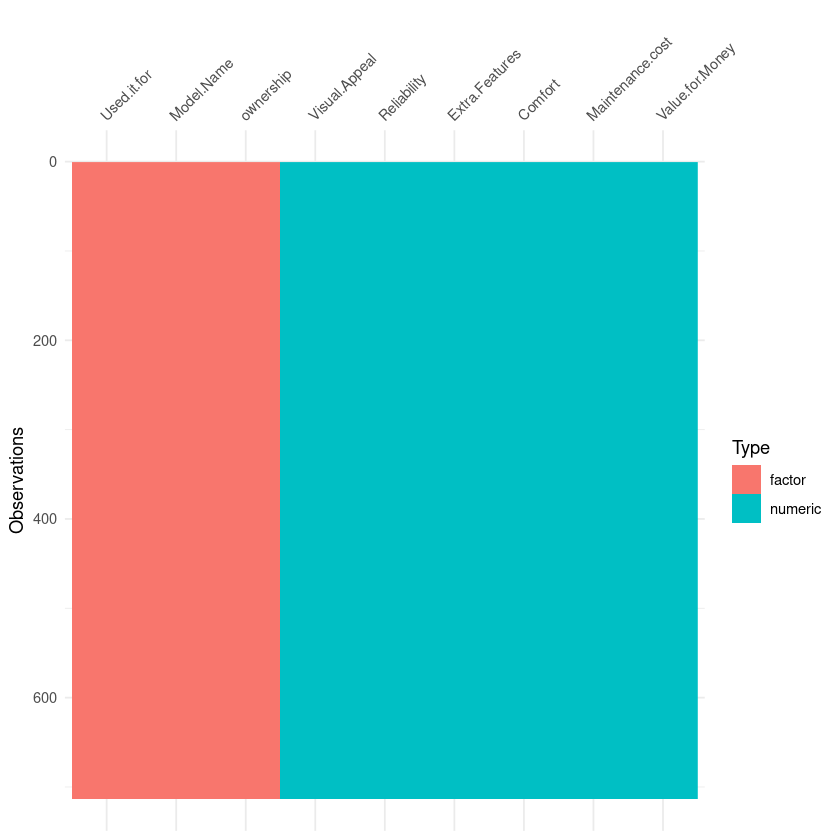

In [251]:
# Check the structure of the data
glimpse(moped_nan_replaced)
miss_var_summary(moped_nan_replaced)
vis_dat(moped_nan_replaced)

## Data Validation Result
Describe the validation tasks you completed and what you found. Have you made any changes to the data to enable further analysis? Remember to describe what you did for every column in the data. 

1. Upon loading the data set, the completeness of the data was checked and it has been found that "Maintenance Cost", "Extra Features", "Value for Money", and "Comfort" contains a lot of missing cases respectively thus these values were replaced by "0". 

2. Then, a column named "Ownership" was added to change the ownership status from "Owned for" column where values that indicates ownership was labeled as "Owned".

3. All character columns are converted into a factor column.

4. Lastly, a separate data frame has been created where all missing values are replaced with "0" which will be used for the model fitting process.



## Exploratory Analysis Process

### Proportion of Mope Ownership and Purpose

New names:
• `` -> `...1`


ownership,Used.it.for,n,prop
<fct>,<fct>,<int>,<dbl>
Never owned,Commuting,81,60
Never owned,Leisure,54,40
Owned,Commuting,472,82
Owned,Leisure,106,18


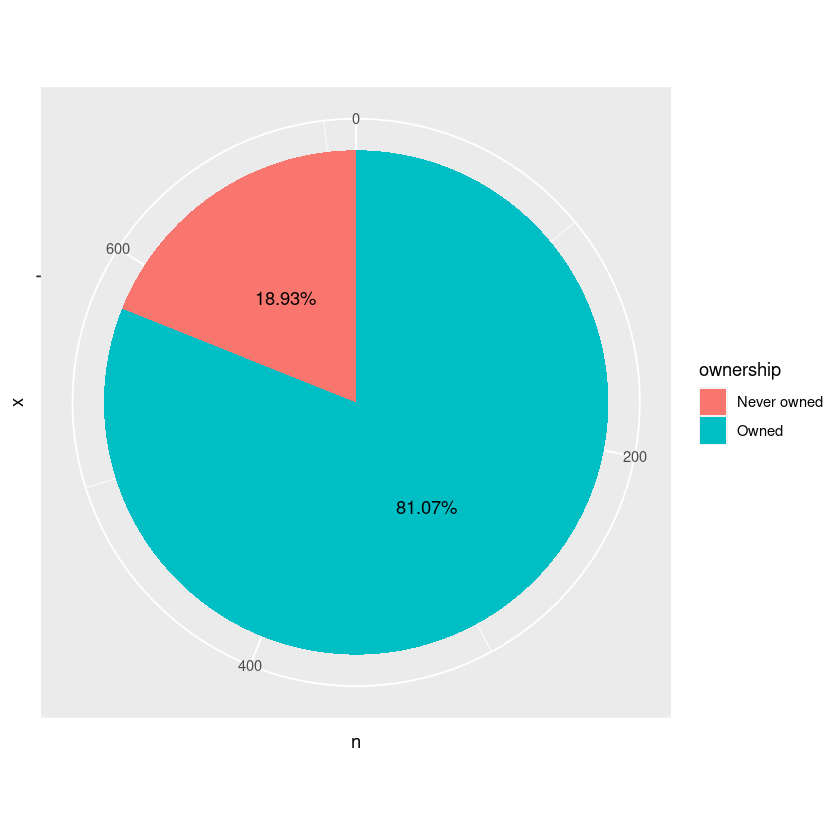

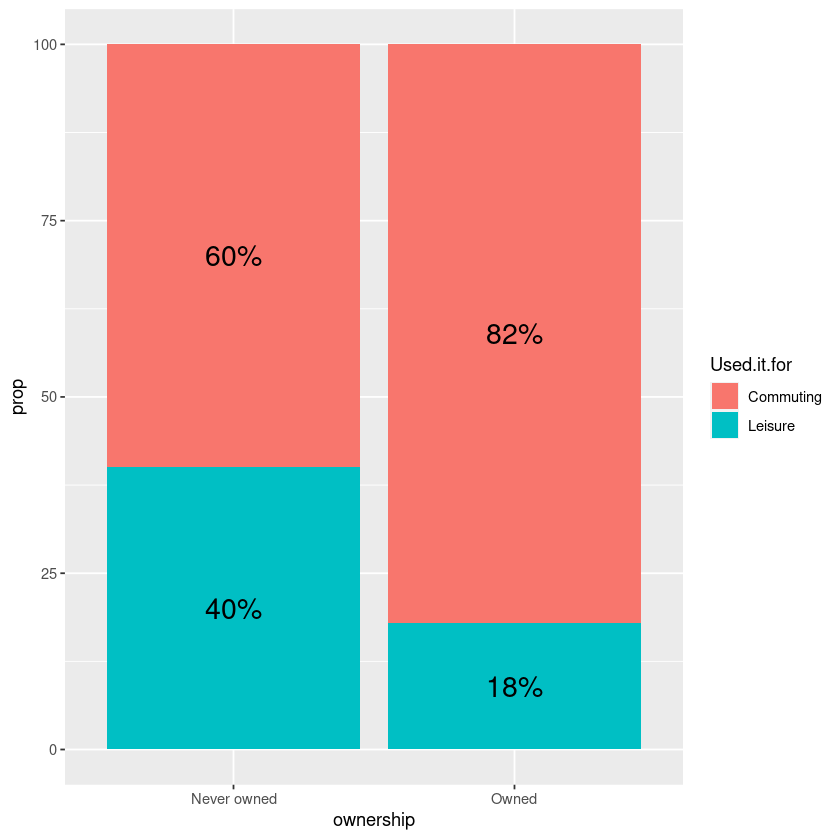

In [252]:
# Exploratory Analysis
# Explore the characteristics of the variables in the data

# Start coding here... 

# Check the proportion of those who owns and do not owns a moped with the purpose of the electric moped. 

moped_nan_replaced|>
	group_by(ownership)|>
	count(ownership)|>
	ungroup()|>
	mutate(prop=round(n/sum(n)*100,2))|>
	ggplot(aes(x="", y=n, fill=ownership)) +
  geom_bar(stat="identity") +
  coord_polar("y", start=0)+
  geom_text(aes(label = paste0(prop,"%")),
           				position = position_stack(vjust = 0.5))




a<-moped_nan_replaced|> 
	group_by(ownership,Used.it.for)|>
	count(ownership)|>
	ungroup()|>
	group_by(ownership)|>
	mutate(prop=round(n/sum(n)*100,0))

head(a)

a |>
	ggplot(aes(ownership,prop, fill=Used.it.for))+
	geom_bar(stat="identity")+
	geom_text(aes(label = paste0(prop,"%")),size = 6, position = position_stack(vjust = 0.5))

It is clear that majority of the reviews came from those who owns the moped based from the pie chart. However, when grouped according to its purpose, the proportion of commuters is higher for those who owned the mopeds. 

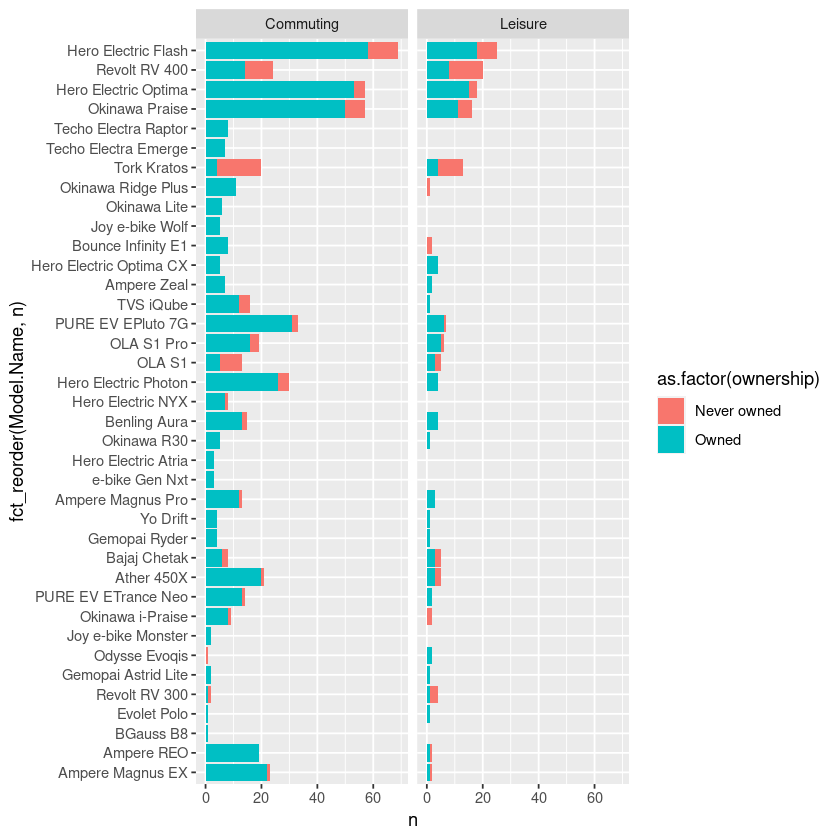

In [253]:
# Check the structure of the ownership status per brand model and purpose

moped_nan_replaced|>
	group_by(Used.it.for, Model.Name, ownership)|>
	count(ownership)|>
	ggplot(aes(fct_reorder(Model.Name,n),n, fill=as.factor(ownership)))+
	geom_col()+
	coord_flip()+
	facet_wrap("Used.it.for")


From the bar graph above, the model names doesn't add additional information on the ownership of moped. Therefore, it will be dropped from the data table.

In [254]:
moped_nan_replaced<-moped_nan_replaced|>select(-Model.Name)
moped_mod<-moped_mod|>select(-Model.Name)

Before proceeding to the exploratory data analysis where means and correlations will be analyzed, the data will be analyzed where missing values are not replaced by 0.

In [255]:
head(moped_mod)

,Used.it.for,Visual.Appeal,Reliability,Extra.Features,Comfort,Maintenance.cost,Value.for.Money,ownership
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Commuting,3,4,NA,4,NA,1,Never owned
2,Leisure,3,1,NA,3,NA,3,Owned
3,Commuting,4,4,NA,5,NA,2,Owned
4,Commuting,1,1,NA,1,NA,1,Owned
5,Commuting,3,4,NA,3,NA,2,Owned
6,Commuting,5,1,NA,5,NA,2,Owned


### Distribution of Ratings According to Ownership and Purpose

ownership,Used.it.for,Value.for.Money,variables,score
<fct>,<fct>,<dbl>,<chr>,<dbl>
Never owned,Commuting,1,Visual.Appeal,3
Never owned,Commuting,1,Reliability,4
Never owned,Commuting,1,Extra.Features,NA
Never owned,Commuting,1,Comfort,4
Never owned,Commuting,1,Maintenance.cost,NA
Owned,Leisure,3,Visual.Appeal,3


Warning message:
“Removed 1270 rows containing non-finite values (stat_count).”
Warning message:
“Removed 1270 rows containing non-finite values (stat_count).”


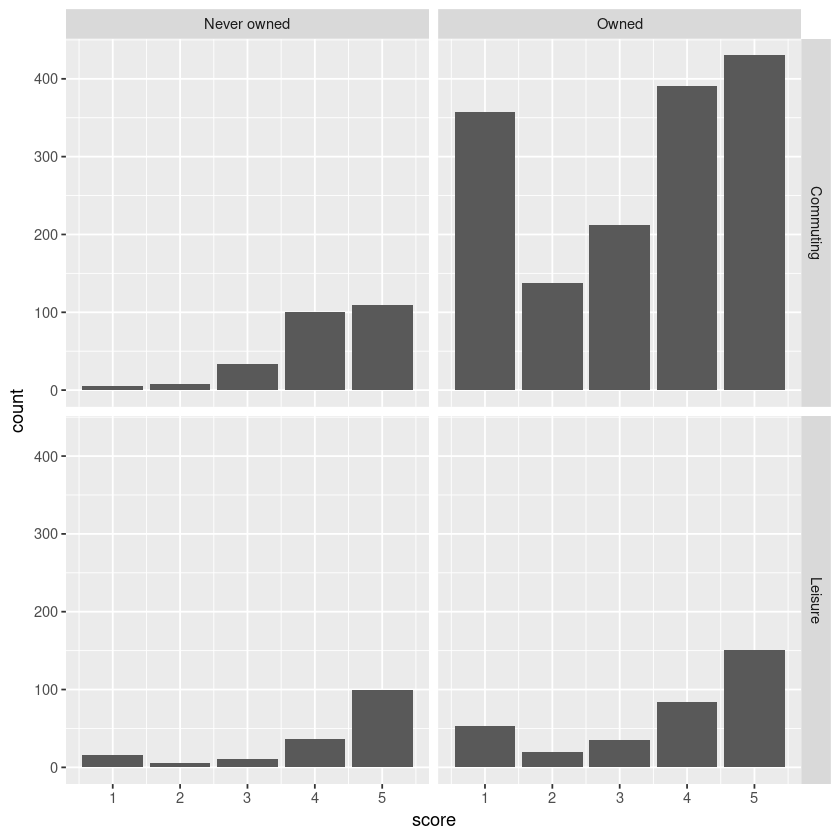

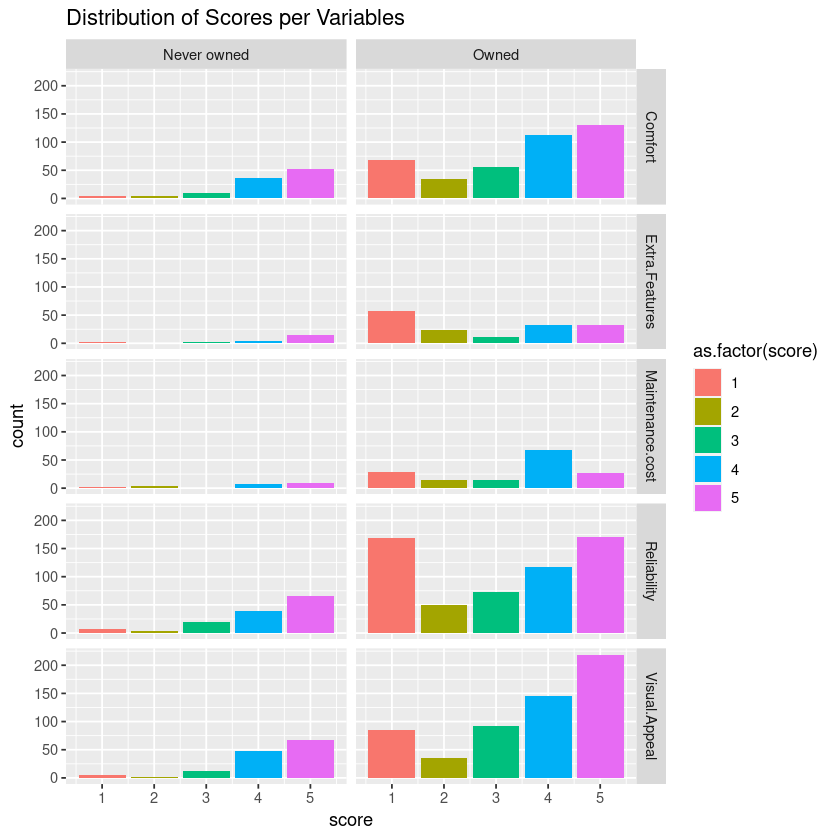

In [256]:
# Convert the data table into a long format so that we can visualize the distribution of the data 

moped_long<-moped_mod|>
	select(ownership,everything())|>
	pivot_longer(cols=3:7, names_to="variables", values_to="score")

head(moped_long)


# Check the overall distribution of ratings in terms of its purpose

moped_long|>
ggplot(aes(score))+
geom_bar()+
facet_grid(vars(Used.it.for), vars(ownership))

# Break down the the distribution of ratings according to rating criterias

moped_long|>
	ggplot(aes(score, fill=as.factor(score)))+
	geom_bar()+
	facet_grid(vars(variables),vars(ownership))+
	labs(title = "Distribution of Scores per Variables")

### Mean Ratings according to Ownership and Purpose

In [257]:
# Compute the overall mean of ratings per ownership

moped_long|>
	group_by(ownership)|>
	summarize_at(vars(score), lst(mean, sd), na.rm=TRUE)

# Compute the overall mean of ratings per ownership

moped_long|>
	group_by(ownership, variables)|>
	summarize_at(vars(score), lst(mean, sd), na.rm=TRUE)

ownership,mean,sd
<fct>,<dbl>,<dbl>
Never owned,4.176471,1.070360
Owned,3.352941,1.527886


New names:
• `` -> `...1`


ownership,variables,mean,sd
<fct>,<chr>,<dbl>,<dbl>
Never owned,Comfort,4.194444,1.0542157
Never owned,Extra.Features,4.125000,1.2958965
Never owned,Maintenance.cost,3.913043,1.3454652
Never owned,Reliability,4.125926,1.0956469
Never owned,Visual.Appeal,4.266667,0.9635135
Owned,Comfort,3.504975,1.4511927
Owned,Extra.Features,2.748428,1.6107572
Owned,Maintenance.cost,3.313725,1.3835052
Owned,Reliability,3.124567,1.6214716


The overall computed mean as well as when it is aggregated accross the numerical variables compliments the insights from the preceding graphs which shows that reviews who never owns a moped have higher ratings as compared to who owns a moped. Additionally, while moped ownership determines the variability in ratings, those who used it for commuting are much more likely to give a moped a low rating.


### Distribution of the overall average rating

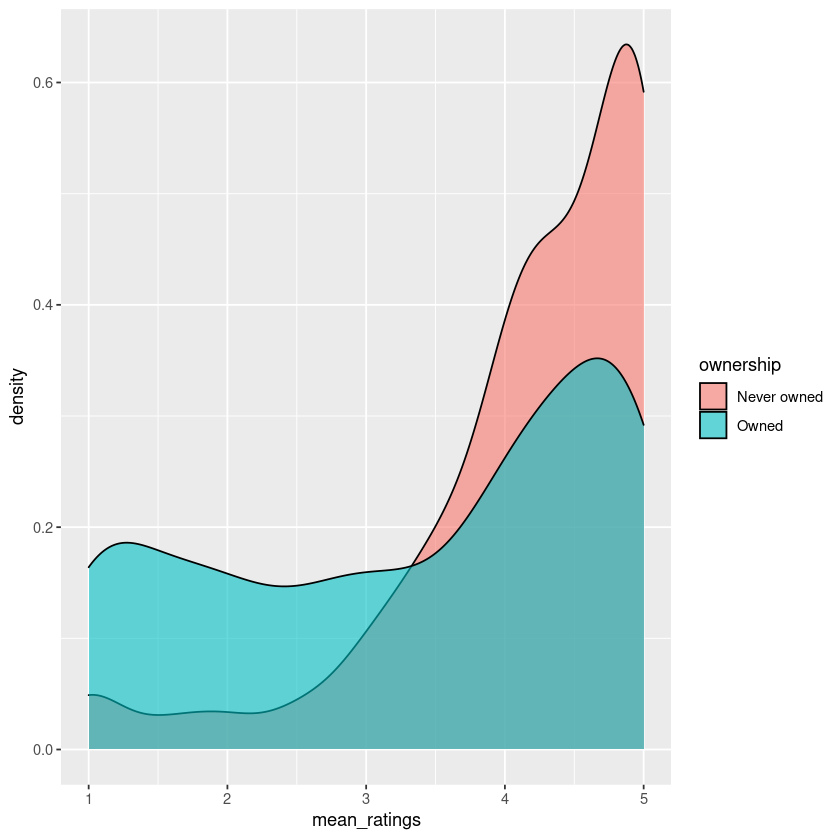

In [258]:

moped_mod|>
	mutate(mean_ratings = rowMeans(moped_mod[,2:7],na.rm=TRUE))|>
	ggplot(aes(mean_ratings, group = ownership, fill=ownership))+
	geom_density(alpha = 0.6)

The density plot shows that the the overall average rating of those those never owns a moped is higher as compared to those who owns a moped.

### Variable Correlation

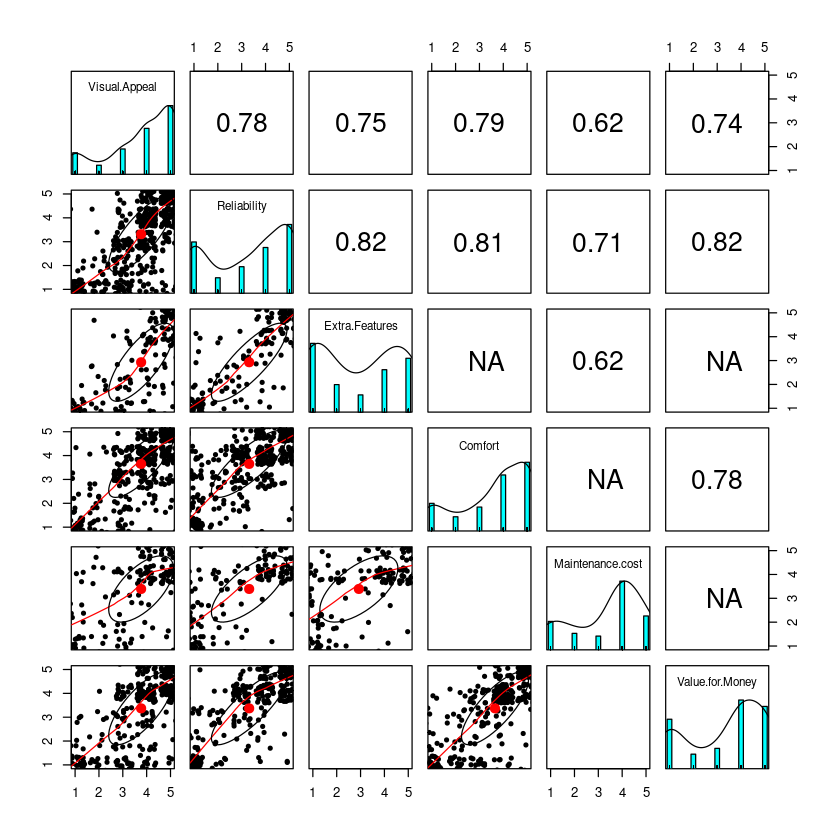

In [259]:
# Check for Correlation between variables.
moped_numerical<-moped_mod[,2:7] #numerical variables

pairs.panels(moped_numerical, jiggle = TRUE)

The boxplot confirms the computed means from the preceding tables that ownership is associated with ratings. From the correlation plot, it shows visual appeal, reliabitliy, extra features, comfort, maintenance cost and value for money are all positively correlated which means that users who likes the product tends to give higher ratings across all metrics.

## Exploratory Analysis Result
Describe what you found in the exploratory analysis. In your description you should:
- Reference at least two different data visualizations you created above to demonstrate the characteristics of variables
- Reference at least one data visualization you created above to demonstrate the relationship between two or more variables
- Describe what your exploratory analysis has told you about the data
- Describe any changes you have made to the data to enable modeling

Summary

The exploratory analysis offers some important features of the data. From the initial pie graph, it shows that 81% of user reviews came from those who owns a moped. From the distribution of ratings when grouped accoding to criteria, owndership, and purpose, as reflected from the bar graphs, and density plot, it appears that moped ownership determines the variability of ratings. Those who never owns moped is higher by about 25% on the overall rating as compared to those who owns a moped. Additionally, it is also shown from the distribution of ratings that those who owns and commutes are the main source of negative reviews.

From the correlation plot, it shows that the numerical criterias are all positively correlated which indicates that users who like their moped unit tend to give a higher rating across all metrics. Some notable features in the correlation matrix are noted which is presented in the data validation process. It appears that some criterias are not placed altogether in a single questionnaire and might some of them are linked together. This is presented when values for 'extra features' and 'maintenance cost' are missing, rows with values for 'value for money' and 'comfort' is available and vice versa.



## Model Fitting Process

### Data Splitting

In [260]:
# Model Fitting
# Choose and fit a baseline model
# Choose and fit a comparison model

# The data table with imputed values will be used for the splitting of the data
# Put 3/4 of the data into the training set 
set.seed(42)
head(moped_nan_replaced)
data_split<-moped_nan_replaced|>
						initial_split(
                           prop = 0.8, 
                           strata = ownership)

# Create dataframes for the two sets:
train_data <- training(data_split) 
test_data <- testing(data_split)

,Used.it.for,Visual.Appeal,Reliability,Extra.Features,Comfort,Maintenance.cost,Value.for.Money,ownership
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Commuting,3,4,0,4,0,1,Never owned
2,Leisure,3,1,0,3,0,3,Owned
3,Commuting,4,4,0,5,0,2,Owned
4,Commuting,1,1,0,1,0,1,Owned
5,Commuting,3,4,0,3,0,2,Owned
6,Commuting,5,1,0,5,0,2,Owned


### Validation Set

In [261]:
# Create a Validation Set
set.seed(42)

cv_folds <-
 vfold_cv(train_data, 
          v = 10, 
          strata = ownership) 

### Model Building

In [262]:
# Logistic Regression

log_spec <-   logistic_reg()|>  
  set_engine(engine = "glm") |> 
  set_mode("classification") 


A logistic regression model has been built as the baseline model.

In [263]:
# Random Forest

rf_spec <- 
  rand_forest() |>
  set_engine("ranger", importance = "impurity") |> 
  set_mode("classification")

In [264]:
# Boosted Tree

xgb_spec <- 
  boost_tree() |>
  set_engine("xgboost") |>
  set_mode("classification") 

In [265]:
# Decision Tree
library(rpart)

dt_spec <- 
  decision_tree() |>
  set_engine("rpart") |>
  set_mode("classification") 

### Feature Engineering

In [266]:
library(workflows)

# Build feature engineering pipeline
moped_rec <- recipe(ownership ~ .,
                    data = train_data) |>
					step_novel(all_nominal(), -all_outcomes())|>
  					step_dummy(all_nominal(), -all_outcomes())

summary(moped_rec)


variable,type,role,source
<chr>,<chr>,<chr>,<chr>
Used.it.for,nominal,predictor,original
Visual.Appeal,numeric,predictor,original
Reliability,numeric,predictor,original
Extra.Features,numeric,predictor,original
Comfort,numeric,predictor,original
Maintenance.cost,numeric,predictor,original
Value.for.Money,numeric,predictor,original
ownership,nominal,outcome,original


### Bundle Recipe and Model

In [267]:
# Logistic Regression

log_wflow <- 
 workflow() |>
 add_recipe(moped_rec) |>
 add_model(log_spec)  

# Random Forest
rf_wflow <- 
 workflow() %>% 
 add_recipe(moped_rec) |>
 add_model(rf_spec) 

# Boosted Tree
xgb_wflow <- 
 workflow() |> 
 add_recipe(moped_rec) |>
 add_model(xgb_spec)

# Decision Tree

dt_wflow <- 
 workflow() |> 
 add_recipe(moped_rec) |>
 add_model(dt_spec)

## Model Fitting Result
Describe your approach to the model fitting. In your description you should:
- Describe what type of machine learning problem you are working on
- Describe which method you selected for the baseline model and explain why you chose this model
- Describe which method you selected for the comparison model and explain why you chose this model

Since the objective is to predict non-owners from the moped reviews, this is a classification problem. The initial baseline model is logistic regression. It will be used as a reference, and ascertain the reliability of other models. In this task, 3 comparison models will be trained from the data set which are typically used for classification task. These are decision tree, random forest, and xgboost (boosted trees). This is to have a variety of models to assess and compare their performance metrics that will suit the objective of the problem.


## Model Evaluation Process

Now we can use our validation set to estimate the performance of our models using the fit_resamples() function to fit the models on each of the folds and store the results.

In [268]:
library(yardstick)
# Model Evaluation
# Choose a metric and evaluate the performance of the two models

# Start coding here... 

log_res <-
  log_wflow |>
  fit_resamples(
    resamples = cv_folds, 
    metrics = metric_set(
      recall, precision, f_meas, 
      accuracy, kap,
      roc_auc, sens, spec),
    control = control_resamples(save_pred = TRUE)
    ) 

rf_res <-
  rf_wflow |>
  fit_resamples(
    resamples = cv_folds, 
    metrics = metric_set(
      recall, precision, f_meas, 
      accuracy, kap,
      roc_auc, sens, spec),
    control = control_resamples(save_pred = TRUE)
    ) 

xgb_res <- 
  xgb_wflow |>
  fit_resamples(
    resamples = cv_folds, 
    metrics = metric_set(
      recall, precision, f_meas, 
      accuracy, kap,
      roc_auc, sens, spec),
    control = control_resamples(save_pred = TRUE)
    ) 

dt_res <- 
  dt_wflow |>
  fit_resamples(
    resamples = cv_folds, 
    metrics = metric_set(
      recall, precision, f_meas, 
      accuracy, kap,
      roc_auc, sens, spec),
    control = control_resamples(save_pred = TRUE)
    ) 

! Fold01: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold02: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold03: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold04: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold05: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold06: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold07: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold08: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold09: preprocessor 1/1, model 1/1 (predictions): prediction from a rank-deficient fit may be misleading

! Fold10: preproces

Collect and bind all the metrics for each model

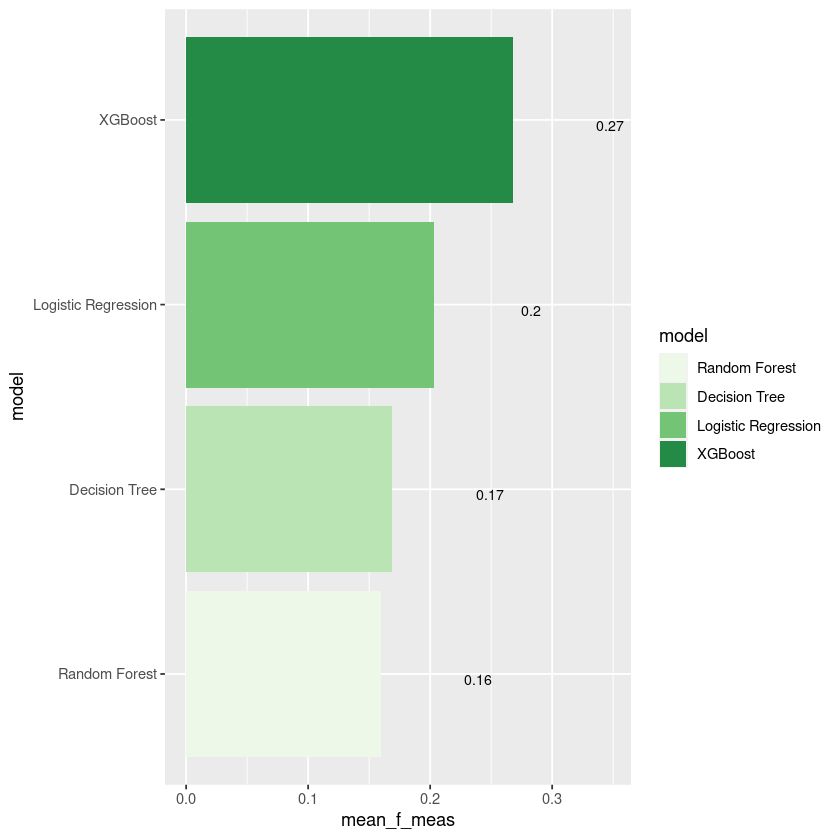

In [269]:
log_metrics <- 
  log_res %>% 
  collect_metrics(summarise = TRUE) %>%
  mutate(model = "Logistic Regression") 

rf_metrics <- 
  rf_res %>% 
  collect_metrics(summarise = TRUE) %>%
  mutate(model = "Random Forest")

xgb_metrics <- 
  xgb_res %>% 
  collect_metrics(summarise = TRUE) %>%
  mutate(model = "XGBoost")


dt_metrics <- 
  dt_res %>% 
  collect_metrics(summarise = TRUE) %>%
  mutate(model = "Decision Tree")

# create dataframe with all models
model_compare <- bind_rows(
                          log_metrics,
                           rf_metrics,
                           xgb_metrics,
							dt_metrics)

# change data structure
model_comp <- 
  model_compare %>% 
  select(model, .metric, mean, std_err) %>% 
  pivot_wider(names_from = .metric, values_from = c(mean, std_err)) 

# show mean F1-Score for every model
model_comp %>% 
  arrange(mean_f_meas) %>% 
  mutate(model = fct_reorder(model, mean_f_meas)) %>% # order results
  ggplot(aes(model, mean_f_meas, fill=model)) +
  geom_col() +
  coord_flip() +
  scale_fill_brewer(palette = "Greens") +
   geom_text(
     size = 3,
     aes(label = round(mean_f_meas, 2), y = mean_f_meas + 0.08),
     vjust = 1
  )

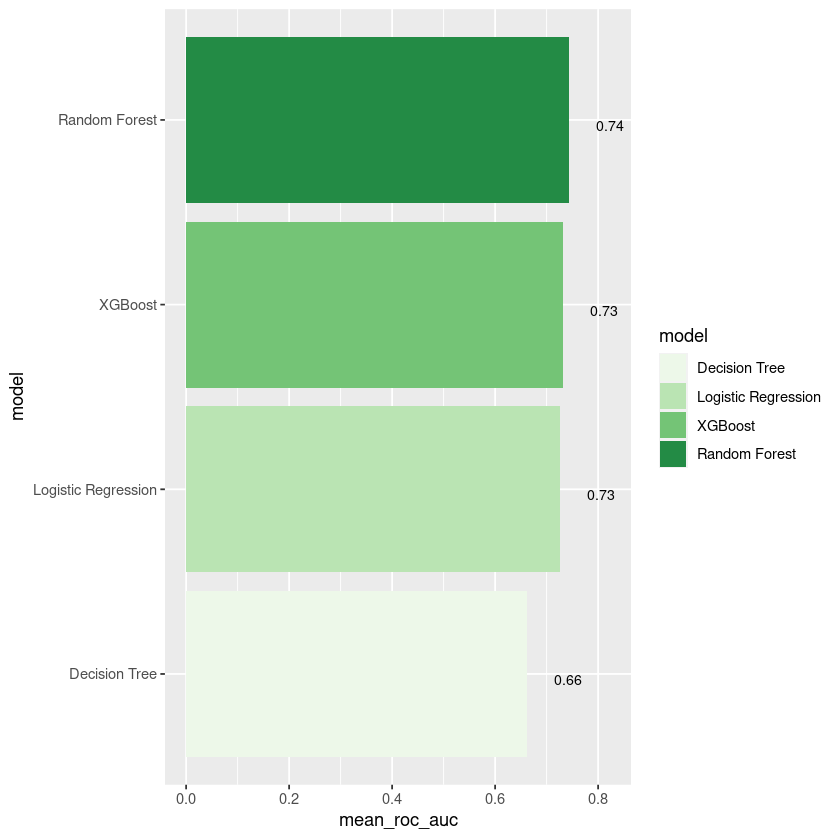

In [270]:
model_comp %>% 
  arrange(mean_roc_auc) %>% 
  mutate(model = fct_reorder(model, mean_roc_auc)) %>%
  ggplot(aes(model, mean_roc_auc, fill=model)) +
  geom_col() +
  coord_flip() +
  scale_fill_brewer(palette = "Greens") + 
     geom_text(
     size = 3,
     aes(label = round(mean_roc_auc, 2), y = mean_roc_auc + 0.08),
     vjust = 1
  )

Model results are quite similar. In this task we choose the F1-Score as performance measure to select the best model over other metric.

In [275]:
model_comp


model,mean_accuracy,mean_f_meas,mean_kap,mean_precision,mean_recall,mean_roc_auc,mean_sens,mean_spec,std_err_accuracy,std_err_f_meas,std_err_kap,std_err_precision,std_err_recall,std_err_roc_auc,std_err_sens,std_err_spec
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Logistic Regression,0.8107186,0.2028205,0.13884134,0.5550000,0.13000000,0.7259011,0.13000000,0.9697502,0.008098025,0.03118710,0.03037203,0.10812801,0.02055475,0.02570993,0.02055475,0.008640091
Random Forest,0.8141356,0.1594406,0.05865708,0.6000000,0.04636364,0.7434707,0.04636364,0.9935245,0.004919432,0.04897102,0.02987923,0.18708287,0.02057261,0.02134211,0.02057261,0.003297396
XGBoost,0.8035757,0.2675708,0.18003357,0.4886905,0.20181818,0.7311267,0.20181818,0.9438945,0.008767054,0.04327005,0.03970253,0.09886724,0.03528189,0.01935689,0.03528189,0.012052961
Decision Tree,0.7965280,0.1688988,0.07090118,0.3854167,0.09272727,0.6623059,0.09272727,0.9610083,0.006323339,0.03220927,0.02556480,0.10309869,0.02431051,0.03059626,0.02431051,0.010106157


XGBoost yields the highest F-measure.

### Last Evaluation on Test Set

In [272]:
last_fit_xgb <- last_fit(xgb_wflow, 
                        split = data_split,
                        metrics = metric_set(
                          recall, precision, f_meas, 
                          accuracy, kap,
                          roc_auc, sens, spec)
                        )

# Show performance metrics

last_fit_xgb %>% 
  collect_metrics()




.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
recall,binary,0.3333333,Preprocessor1_Model1
precision,binary,0.4500000,Preprocessor1_Model1
f_meas,binary,0.3829787,Preprocessor1_Model1
accuracy,binary,0.7972028,Preprocessor1_Model1
kap,binary,0.2648467,Preprocessor1_Model1
sens,binary,0.3333333,Preprocessor1_Model1
spec,binary,0.9051724,Preprocessor1_Model1
roc_auc,binary,0.7089719,Preprocessor1_Model1


### Identification of variable importance

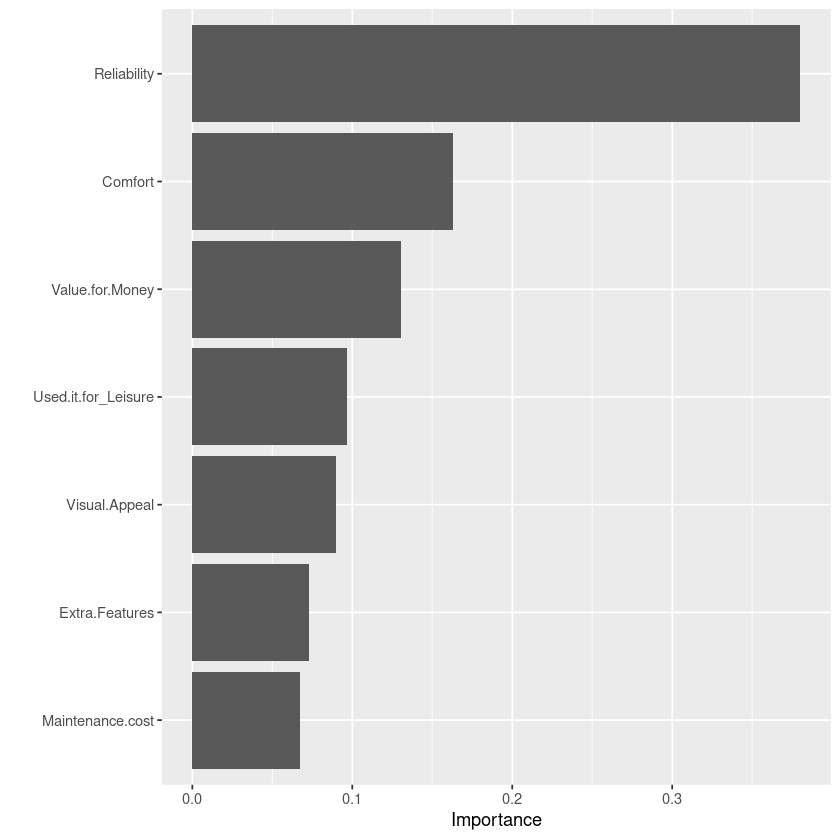

In [273]:
library(vip)

last_fit_xgb %>% 
  pluck(".workflow", 1) %>%   
  extract_fit_parsnip() %>% 
  vip(num_features = 10)

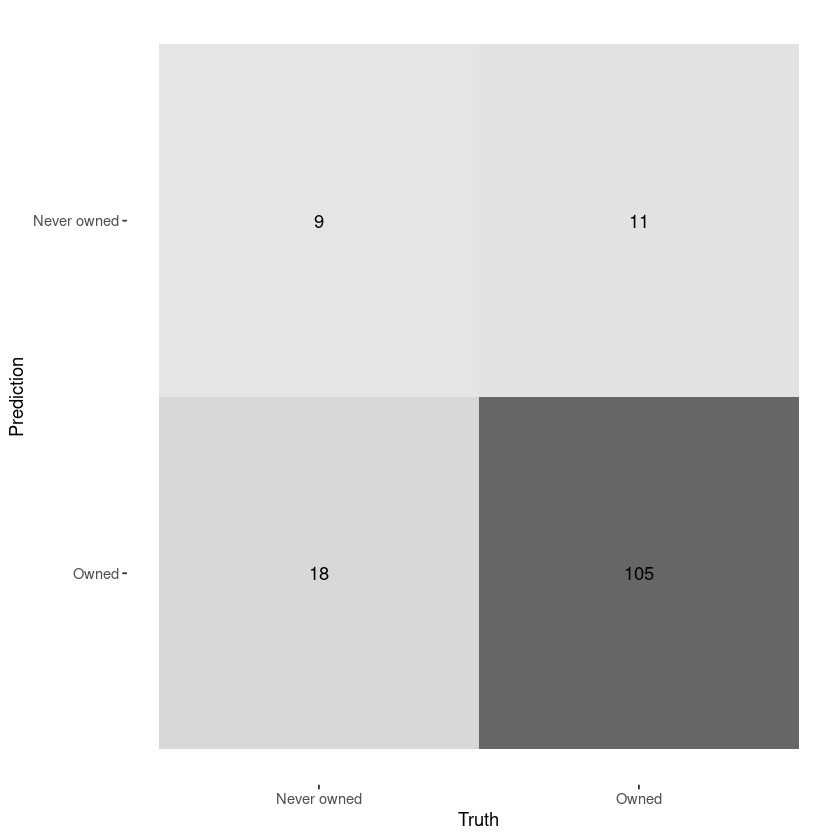

In [274]:
last_fit_xgb %>%
  collect_predictions() %>% 
  conf_mat(ownership, .pred_class) %>% 
  autoplot(type = "heatmap")

## Model Evaluation
Explain what the results of your evaluation tell you. You should:
- Describe which metric you have selected to compare the models and why
- Explain what the outcome of this evaluation tells you about the performance of your models
- Identify, based on the evaluation, which you would consider to be the better performing approach


This is a classification task whose primary objective is to predict the moped reviews who are coming from the non-owners and eliminate these reviews so we can focus on reivews from moped owners. However, while we want to increase the accuracy of classifying the non-owners from the owners, it has a risk of discarding too many owners reviews. Therefore, we select the model with a good combination of precision and recall metrics since we want to focus on discarding the maximum number of non-owner reviews without seriously damaging our overall accuracy. Thus, F1-score will be selected as a performance metrics for this problem.
Among the four models, the best model is the XGBoost with an F1-Score of 0.2676 as well as having the highest recall of .2018 on the validation set. 

With this, the best performing model according to the preferred performance metrics is the XGBoost having an overall accuracy of .7972 and an f1-score of .383. Additionally, upon assessing the variable importance from the model, 'reliability' ranks the highest.




## ✅  When you have finished...
- Publish your Workspace using the option on the left
- Check the published version of your report:
	- Can you see everything you want us to grade?
    - Are all the graphics visible?
- Review grading rubric, have you included everything that will be graded?
- Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your case study